# Introduction

Hello, I'm **Wesley**, nice to meet you. 👋

**Transfer learning** is the deep learning technique of using a large pre-trained base model (e.g. BERT) and adapating it to a particular domain to do a particular task. The name we call this type of training in the transfer learning domain is *fine-tuning*.

**Traditionally**, the process of *fine-tuning* has usually been done with **all** the layers of a base model as trainable parameters with a low learning rate to get the **best performance** possible. This is done in the hopes that we can reuse most of the **semantic representations** that it had learned from its the pretrained dataset while having the flexibility to adapt the model to a different domain with similar dataset characteristics. For example, **BERT** is pre-trained on *English* datasets (**BookCorpus** and **Wikipedia**), and so it would be **ideal** that we *fine-tune* the model on an *English* dataset to leverage its previous understanding of English and use it to do other tasks like sentiment classification to have **minimal** data distribution shift.

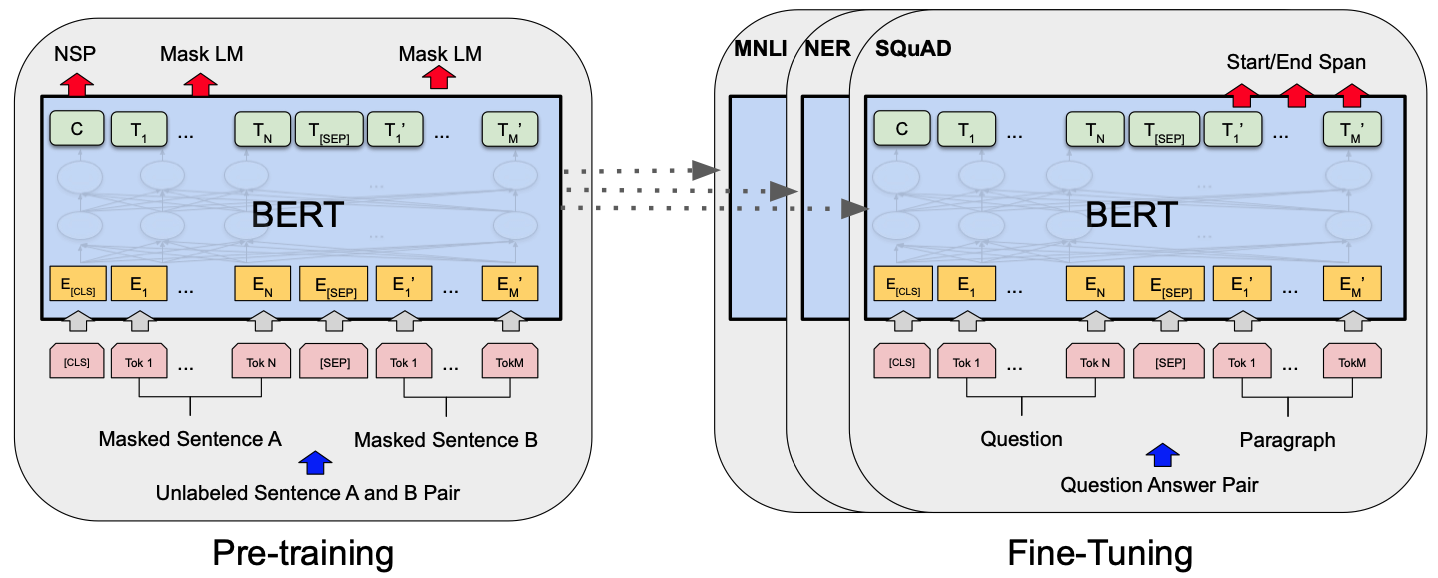

Since we don't have to train the model from **scratch** to achieve **state-of-the-art** results, transfer learning saves us **substantial amount of compute time and cost** and **allows anyone with just even a single GPU** to adapt a pre-trained base model to their own domain for **high-speed prototyping** and even an eventual **production deployment**.

The question we will explore in this notebook is **"Can we save even more compute time and cost by freezing certain layers of the base model while achieving marginal reduction in relative performance compared to that of the traditional unfrozen pre-trained base model"**? Let's find out!

We will be using the **[HuggingFace DistilBert model](https://huggingface.co/distilbert-base-uncased)** to do a **sentiment classification** on the **[Stanford Sentiment dataset (SST2)](https://paperswithcode.com/dataset/sst)** in this experiment to **measure NLP transfer learning performance differences with layer freezing**.

**TLDR**:
- Freezing the embedding layer seems to increase test performance, while decreasing around half the trainable parameters.
- Freezing more layers does decrease test performance, but not as much as you think.
- Freezing most layers except the l or 2 transformers layer seems to be the goldilock zone to reduce compute time and cost while achieving similar unfrozen results.

**⭐️ If you like these types of notebooks, LIKE 👍 it so that I know to make more of these.  Enjoy! 😁**

# Setup Python Libraries

In [29]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm matplotlib nltk wordcloud--quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate|^tqdm|^matplotlib|^nltk|^wordcloud'

ERROR: Could not find a version that satisfies the requirement wordcloud--quiet (from versions: none)
ERROR: No matching distribution found for wordcloud--quiet


datasets==2.1.0
evaluate==0.4.0
matplotlib==3.7.1
matplotlib-inline @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-inline_1660814786464/work
matplotlib-venn==0.11.9
nltk==3.2.4
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=de0c947f8c06a637392b3efa76aad3ac1d91effd6481f8154aeeb4303f12d133
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=178c0fd167dd56970d14aa26ff4e98d8963ead026f00b4f36d6d7fc93421f317
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==1.0.0
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=89c1e3cb8aa36dc34a82501799a7d364ca4a4f6d447d86324a9aec7036fa4702
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=4ed53c3d788b3394127da0e3207891e604d52f3b7ea69e5be0a895cc6029ed4a
tqdm @ file:///home/conda/feedstock_root/build_artifacts/tqdm_1677948868469/work
transformers==4.28.1
wordcloud==1.9.2


# Clone Dataset

In [2]:
# let's import some specific libraries for the EDA
from datasets import load_dataset

from collections import Counter
from tqdm.notebook import tqdm

from wordcloud import WordCloud, STOPWORDS

from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# let's clone the dataset from HuggingFace Hub
# source: https://huggingface.co/datasets/SetFit/sst2
raw_datasets = load_dataset('SetFit/sst2')
raw_datasets

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/SetFit--sst2-4811211b52125821/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 6920
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1821
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 872
    })
})

# Exploratory Data Analysis

In [4]:
# let's look at an example
example = raw_datasets['train'][0]
example

{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films',
 'label': 1,
 'label_text': 'positive'}

## Plot Data Class Imbalance

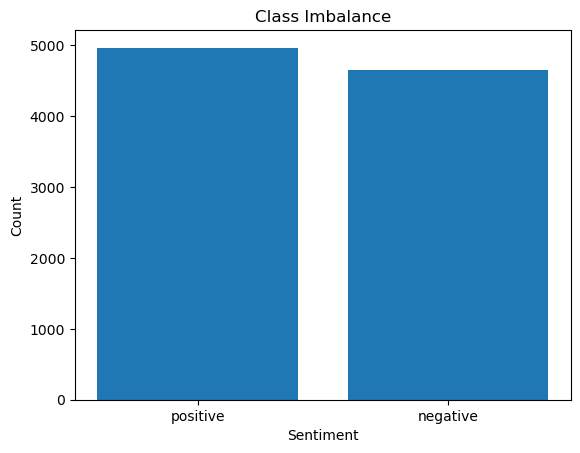

In [5]:
label_counter = Counter()
for split_type in ['train', 'validation', 'test']:
    label_counter.update(raw_datasets[split_type]['label_text'])

plt.bar(label_counter.keys(), label_counter.values())
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()

## Plot Word Clouds

In [6]:
# let's get the counts of each word in each sentiment class
stopwords_set = set(stopwords.words('english') + ['br']).union(STOPWORDS)
positive_word_counter = Counter()
negative_word_counter = Counter()

for split_type in ['train', 'test']:
    for example in tqdm(raw_datasets[split_type]):
        word_list = list(filter(lambda x: x.isalpha() and x not in stopwords_set, map(lambda x: x.lower(), wordpunct_tokenize(example['text']))))
        if example['label'] == 1:
            positive_word_counter.update(word_list)
        else:
            negative_word_counter.update(word_list)

  0%|          | 0/6920 [00:00<?, ?it/s]

  0%|          | 0/1821 [00:00<?, ?it/s]

In [7]:
# we define a function to generate a wordcloud based on their frequencies
# the higher the frequency of word, the bigger it is in the word cloud
# we are capping the words to 100 to improve visibility
def plot_wordcloud(word_counter, title):
    wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(frequencies=word_counter)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

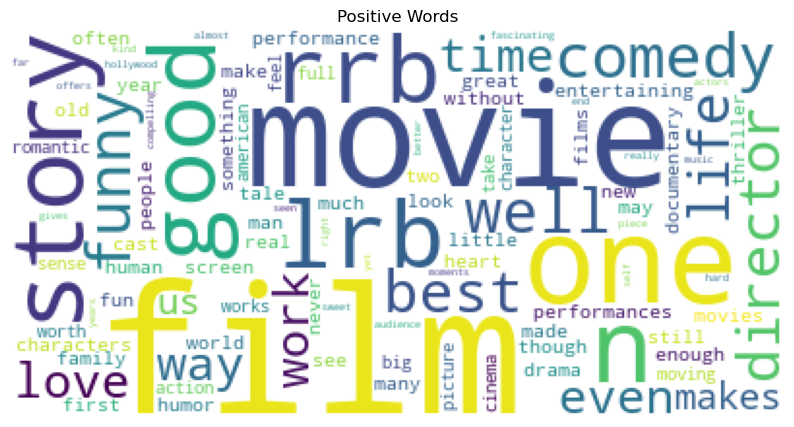

In [8]:
# let's plot a wordcloud for all POSITIVE words
plot_wordcloud(word_counter=positive_word_counter, title='Positive Words')

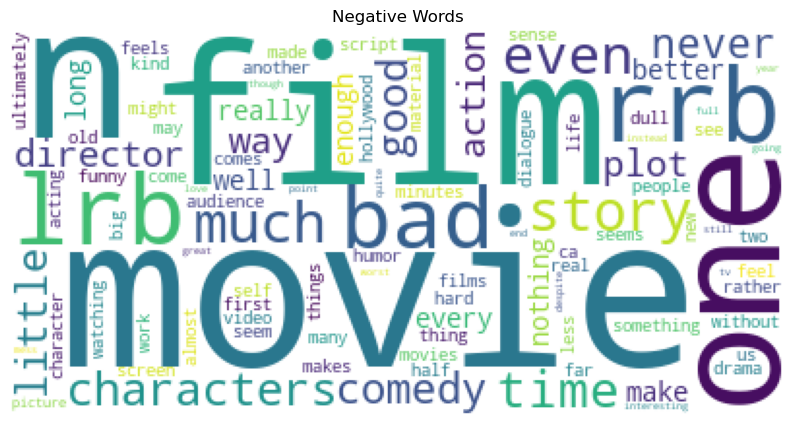

In [9]:
# let's plot a wordcloud for all NEGATIVE words
plot_wordcloud(word_counter=negative_word_counter, title='Negative Words')

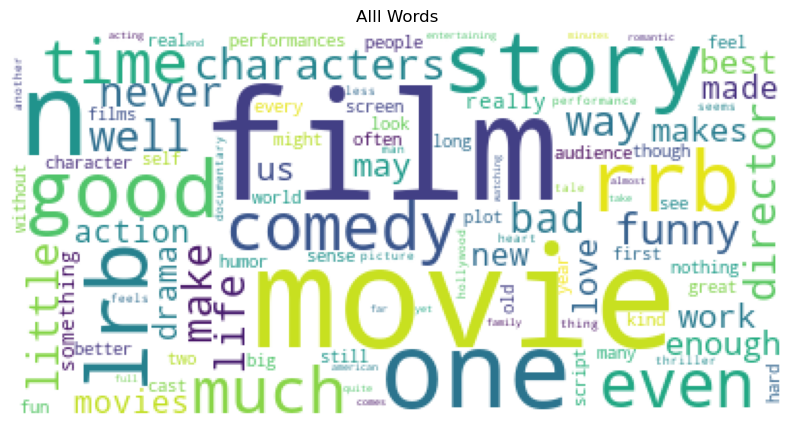

In [10]:
# let's plot a wordcloud for ALL words
# interestingly, there's a lot of talk of film and movies haha
plot_wordcloud(word_counter=positive_word_counter+negative_word_counter, title='Alll Words')

# Setup Training

In [11]:
import numpy as np
import torch

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, logging
from transformers.trainer_callback import PrinterCallback
from datasets import DatasetDict
import evaluate

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"DEVICE: {DEVICE}")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

DEVICE: cuda


## Tokenize Dataset

In [12]:
# let's clone the pre-trained DistilBert tokenizer from HuggingFace
# source: https://huggingface.co/distilbert-base-uncased
CHECKPOINT = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

In [13]:
# split test set into half for validation
val_test_datasets = raw_datasets['test'].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

datasets = DatasetDict({
    'train': raw_datasets['train'],
    'validation': val_test_datasets['train'],
    'test': val_test_datasets['test'],
})

# tokenize datasets
datasets = datasets.map(lambda batch: tokenizer(batch['text'], truncation=True), batched=True, remove_columns=['text', 'label_text'])
datasets

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 910
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 911
    })
})

## Clone Model

In [14]:
NUM_LABELS = 2
ID2LABEL = {0:'NEGATIVE', 1:'POSITIVE'}
LABEL2ID = {'NEGATIVE':0, 'POSITIVE':1}

# this get the total and trainable number of parameters
def get_model_num_parameters(model):
    total_num_trainable_params = 0
    for _, layer_params in model.named_parameters():
        if layer_params.requires_grad:
            total_num_trainable_params += layer_params.numel()

    return {
        'trainable_num_parameters': total_num_trainable_params,
        'total_num_parameters': model.num_parameters()
    }

# I made this as there is a bug regarding the use of torchsummary.summary
def print_model_summary(model):
    print("-"*89)
    print(f"| Layer Name                                              | # of Parameters | Trainable |")
    print("-"*89)
    total_num_trainable_params = 0
    for layer_name, layer_params in model.named_parameters():
        if layer_params.requires_grad:
            total_num_trainable_params += layer_params.numel()
        print(f"| {layer_name:<55} | {layer_params.numel():<15} | {str(layer_params.requires_grad):<9} |")
    print("-"*89)
    print(f"| Total # of Parameters: {total_num_trainable_params:<62} |" )
    print("-"*89)

In [15]:
# let's clone the pre-trained DistilBert model from HuggingFace and print it's architecture
# source: https://huggingface.co/distilbert-base-uncased

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)
print_model_summary(model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.

-----------------------------------------------------------------------------------------
| Layer Name                                              | # of Parameters | Trainable |
-----------------------------------------------------------------------------------------
| distilbert.embeddings.word_embeddings.weight            | 23440896        | True      |
| distilbert.embeddings.position_embeddings.weight        | 393216          | True      |
| distilbert.embeddings.LayerNorm.weight                  | 768             | True      |
| distilbert.embeddings.LayerNorm.bias                    | 768             | True      |
| distilbert.transformer.layer.0.attention.q_lin.weight   | 589824          | True      |
| distilbert.transformer.layer.0.attention.q_lin.bias     | 768             | True      |
| distilbert.transformer.layer.0.attention.k_lin.weight   | 589824          | True      |
| distilbert.transformer.layer.0.attention.k_lin.bias     | 768             | True      |
| distilbe

# Fine-Tune with Layer Freezing

**We will be fine-tuning 7 types of model architectures with DistilBert:**
1. No Frozen Layers
2. Frozen Embedding
3. Frozen Embedding and Transformer Layer 1
4. Frozen Embedding and Transformer Layer 1,2
5. Frozen Embedding and Transformer Layer 1,2,3
6. Frozen Embedding and Transformer Layer 1,2,3,4
7. Frozen Embedding and Transformer Layer 1,2,3,4,5

**Training Setup:**
- Number of Epochs: 5
- Batch Size: 32
- Loss Criterion: AdamW
- Metrics: Accuracy, F1
- Device: CUDA
- Keep: Model with Lowest Validation Loss

**Comparison Metrics:**
- Train Runtime
- Train Samples per Second
- Train Steps per Second
- Train Loss
- Validation Loss
- Validation Accuracy
- Validation F1
- Test Accuracy
- Test F1

In [16]:
# we use accuracy and f1 as performance measures
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

In [17]:
# suppress model clone warning of needing to fine-tune on down-stream task
logging.set_verbosity_error()

def init_model(frozen_layers = [], print_model_summary = True):
    # let's clone the pre-trained DistilBert model  from HuggingFace
    # source: https://huggingface.co/distilbert-base-uncased
    model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)

    for frozen_layer_name in frozen_layers:
        for layer_name, layer_params in model.named_parameters():
            if frozen_layer_name in layer_name:
                layer_params.requires_grad = False
    
    if print_model_summary: print_model_summary(model)

    return model

def train_eval_loop(frozen_layers = [], print_model_summary = True, print_model_training = True):
    # we will be naming the run based on the last frozen layer
    name = frozen_layers[-1] if frozen_layers else 'none'
    print(f"NAME: {name}")
    
    print(f"\tFROZEN LAYERS: {frozen_layers}")
    
    print("\tINITIALIZE MODEL")
    model = init_model(frozen_layers = frozen_layers, print_model_summary = print_model_summary)
    num_parameters = get_model_num_parameters(model)
    
    print ("\tSETUP TRAINER")
    training_args = TrainingArguments(
        seed=SEED,
        output_dir='results',
        optim='adamw_torch',
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        save_strategy='epoch',
        evaluation_strategy='epoch',
        load_best_model_at_end=True,
        report_to='none',
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=datasets['train'],
        eval_dataset=datasets['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    # suppress callback stdout
    trainer.remove_callback(PrinterCallback)
    
    print("\tGET UNFINE-TUNED TEST PERFORMANCE")
    unfinetuned_test_metrics = trainer.evaluate(datasets['test'])
    if print_model_training: print(f"\t\t{unfinetuned_test_metrics}")
    
    print("\tTRAIN MODEL")
    train_metrics = trainer.train().metrics
    if print_model_training: print(f"\t\t{train_metrics}")
    
    print("\tGET VALIDATION PERFORMANCE")
    validation_metrics = trainer.evaluate()
    if print_model_training: print(f"\t\t{validation_metrics}")
    
    print("\tGET FINE-TUNED TEST PERFORMANCE")
    finetuned_test_metrics =  trainer.evaluate(datasets['test'])
    if print_model_training: print(f"\t\t{finetuned_test_metrics}")
    
    return {
        'name': name,
        'frozen_layers': frozen_layers,
        'unfinetuned_test_metrics': unfinetuned_test_metrics,
        'train_metrics': train_metrics,
        'validation_metrics': validation_metrics,
        'finetuned_test_metrics': finetuned_test_metrics,
        **num_parameters
    }

In [18]:
DISTILBERT_LAYERS = ['embedding', 'transformer.layer.0', 'transformer.layer.1', 'transformer.layer.2', 'transformer.layer.3', 'transformer.layer.4', 'transformer.layer.5']

results = []
for i in tqdm(range(len(DISTILBERT_LAYERS)+1)):
    frozen_layers = DISTILBERT_LAYERS[:i]
    metrics = train_eval_loop(frozen_layers = frozen_layers, print_model_summary=False, print_model_training=False)
    results.append(metrics)

  0%|          | 0/8 [00:00<?, ?it/s]

NAME: none
	FROZEN LAYERS: []
	INITIALIZE MODEL
	SETUP TRAINER
	GET UNFINE-TUNED TEST PERFORMANCE
	TRAIN MODEL
	GET VALIDATION PERFORMANCE
	GET FINE-TUNED TEST PERFORMANCE
NAME: embedding
	FROZEN LAYERS: ['embedding']
	INITIALIZE MODEL
	SETUP TRAINER
	GET UNFINE-TUNED TEST PERFORMANCE
	TRAIN MODEL
	GET VALIDATION PERFORMANCE
	GET FINE-TUNED TEST PERFORMANCE
NAME: transformer.layer.0
	FROZEN LAYERS: ['embedding', 'transformer.layer.0']
	INITIALIZE MODEL
	SETUP TRAINER
	GET UNFINE-TUNED TEST PERFORMANCE
	TRAIN MODEL
	GET VALIDATION PERFORMANCE
	GET FINE-TUNED TEST PERFORMANCE
NAME: transformer.layer.1
	FROZEN LAYERS: ['embedding', 'transformer.layer.0', 'transformer.layer.1']
	INITIALIZE MODEL
	SETUP TRAINER
	GET UNFINE-TUNED TEST PERFORMANCE
	TRAIN MODEL
	GET VALIDATION PERFORMANCE
	GET FINE-TUNED TEST PERFORMANCE
NAME: transformer.layer.2
	FROZEN LAYERS: ['embedding', 'transformer.layer.0', 'transformer.layer.1', 'transformer.layer.2']
	INITIALIZE MODEL
	SETUP TRAINER
	GET UNFINE-TUNED

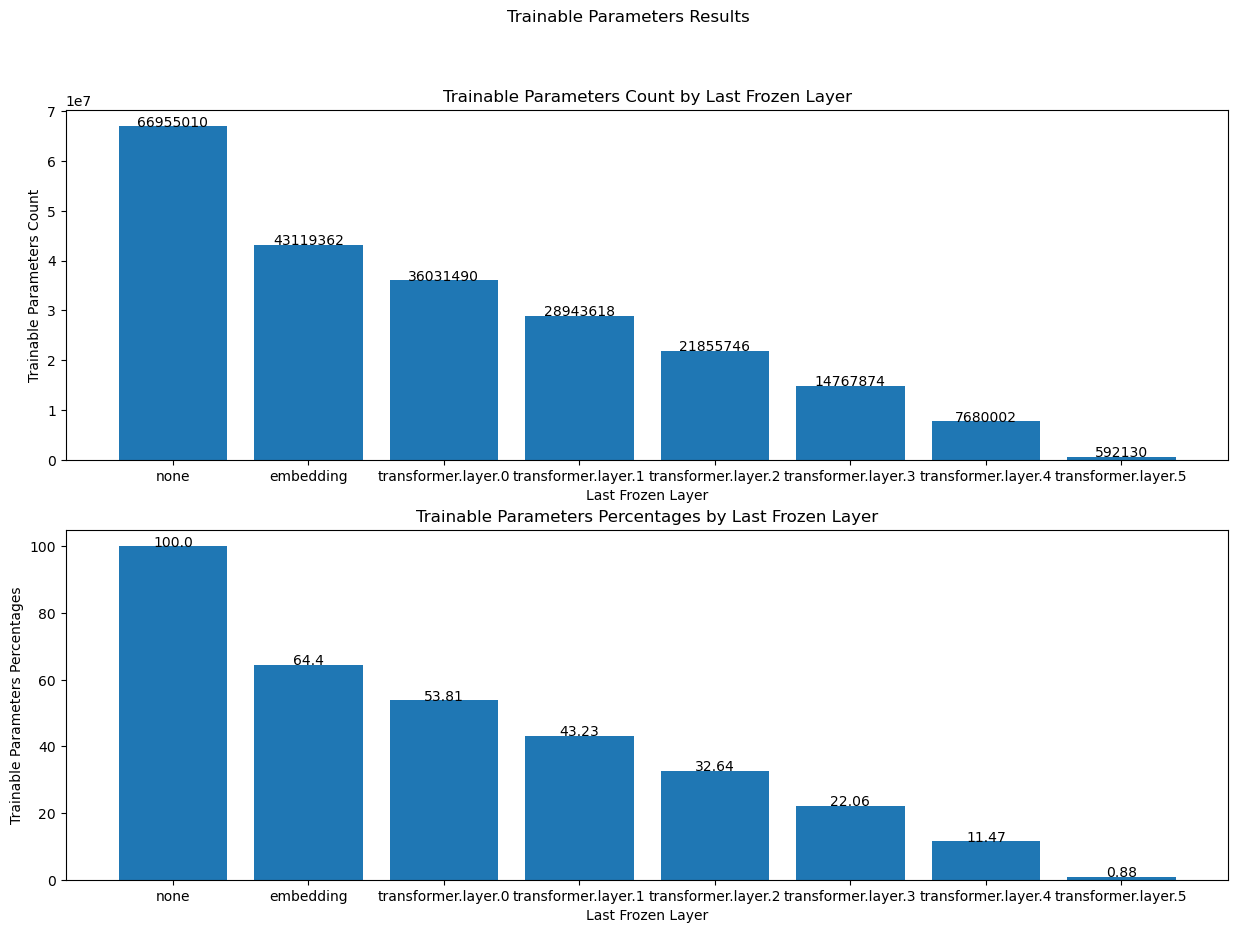

In [19]:
# get trainable num parameters
name_list = []
trainable_num_parameters = []
trainable_num_parameters_perc = []
for row in results:
    name_list.append(row['name'])
    trainable_num_parameters.append(row['trainable_num_parameters'])
    trainable_num_parameters_perc.append(float(f"{row['trainable_num_parameters']/row['total_num_parameters']*100:.2f}"))
    

# plot graph
fig, axs = plt.subplots(nrows=2, figsize=(15,10))
fig.suptitle('Trainable Parameters Results')
    # plot count
xlabel0 = 'Last Frozen Layer'
ylabel0 = 'Trainable Parameters Count'
axs[0].bar(name_list, trainable_num_parameters)
axs[0].set(xlabel=xlabel0, ylabel=ylabel0)
axs[0].set_title(f"{ylabel0} by {xlabel0}")
for i in range(len(trainable_num_parameters)):
    axs[0].text(x=i, y=trainable_num_parameters[i], s=trainable_num_parameters[i], ha='center')
    # plot percentages
xlabel1 = 'Last Frozen Layer'
ylabel1 = 'Trainable Parameters Percentages'
axs[1].bar(name_list, trainable_num_parameters_perc)
axs[1].set(xlabel=xlabel1, ylabel=ylabel1)
axs[1].set_title(f"{ylabel1} by {xlabel1}")
for i in range(len(trainable_num_parameters_perc)):
    axs[1].text(x=i, y=trainable_num_parameters_perc[i], s=trainable_num_parameters_perc[i], ha='center')

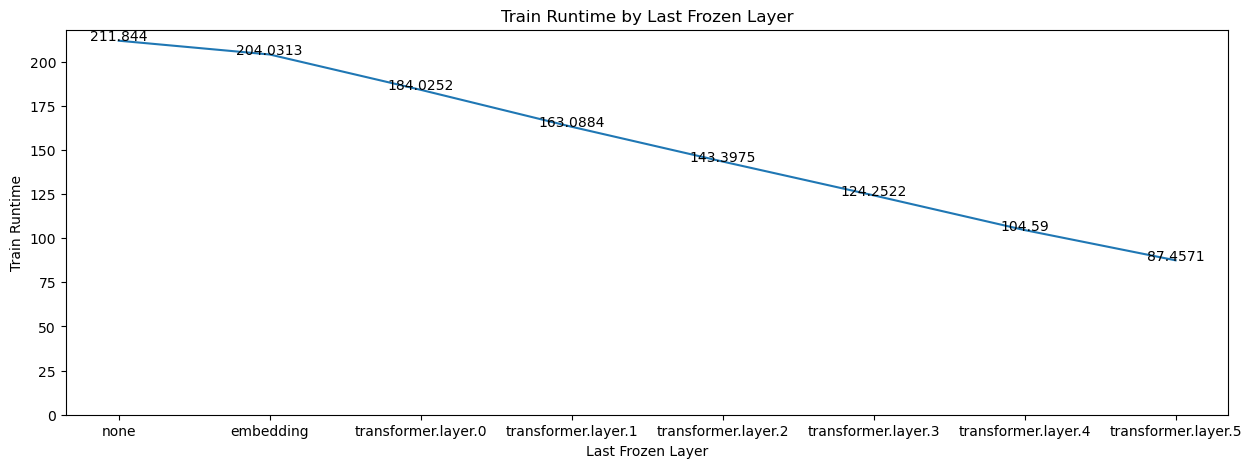

In [20]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['train_metrics']['train_runtime']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Train Runtime'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

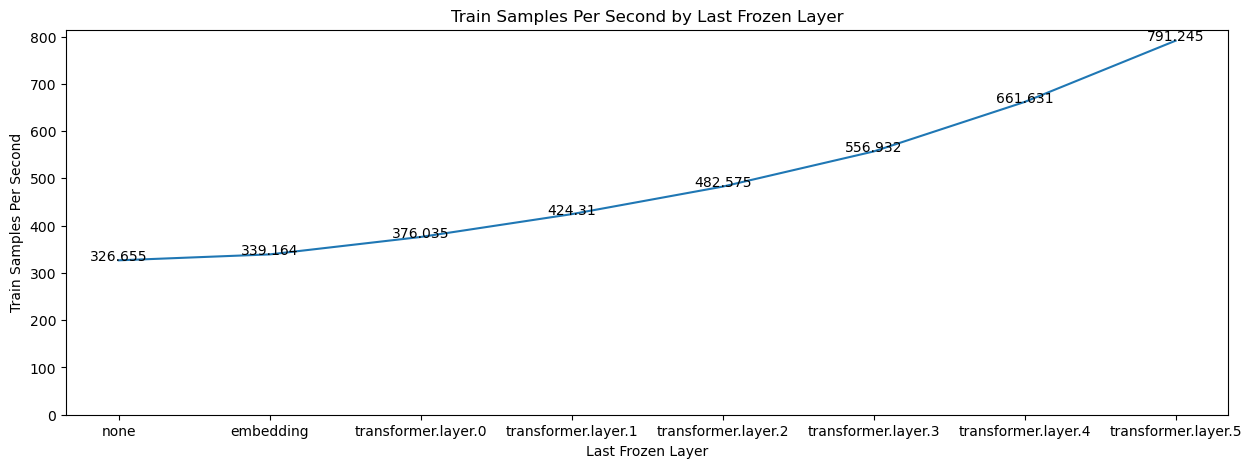

In [21]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['train_metrics']['train_samples_per_second']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Train Samples Per Second'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

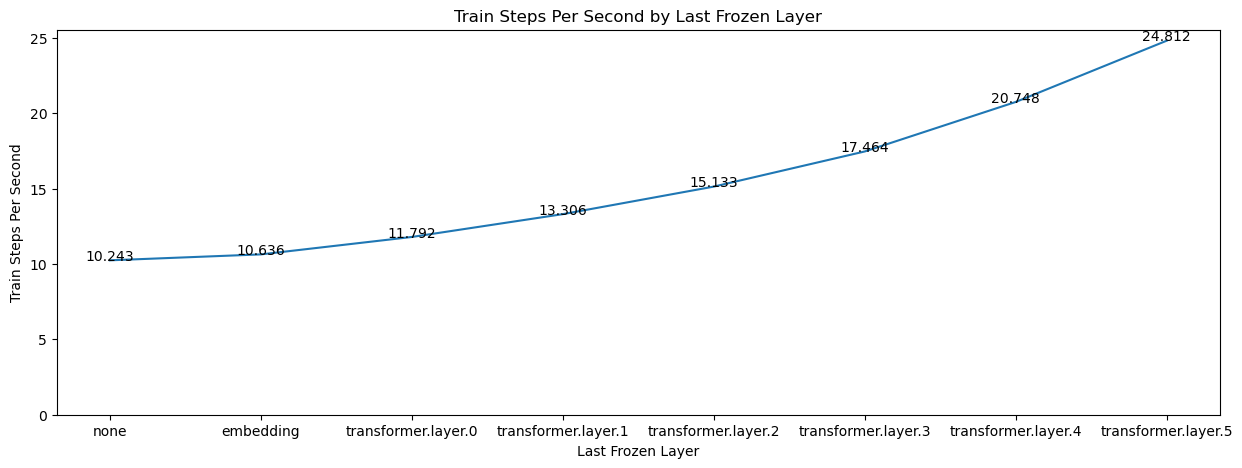

In [22]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['train_metrics']['train_steps_per_second']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Train Steps Per Second'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

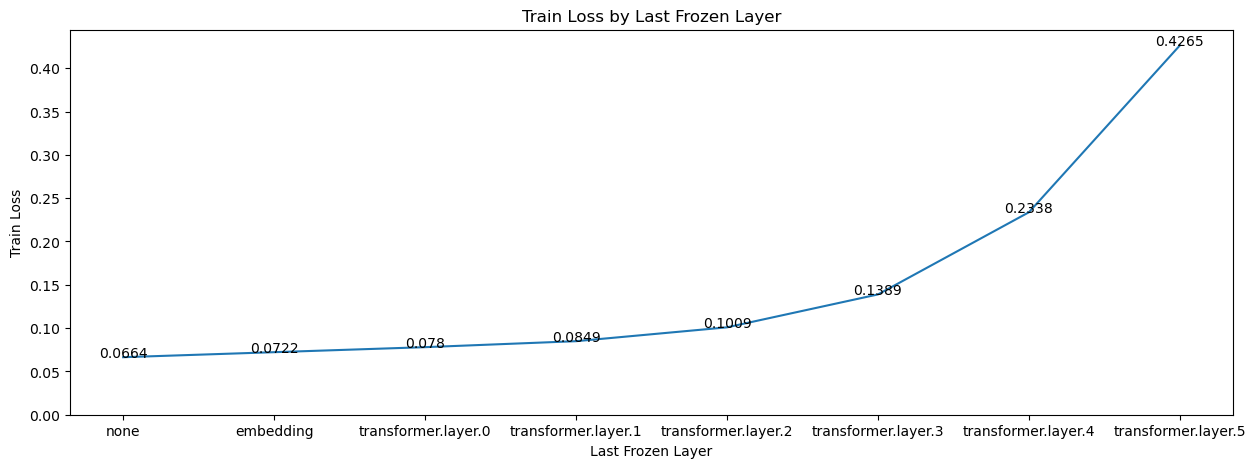

In [23]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['train_metrics']['train_loss']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Train Loss'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

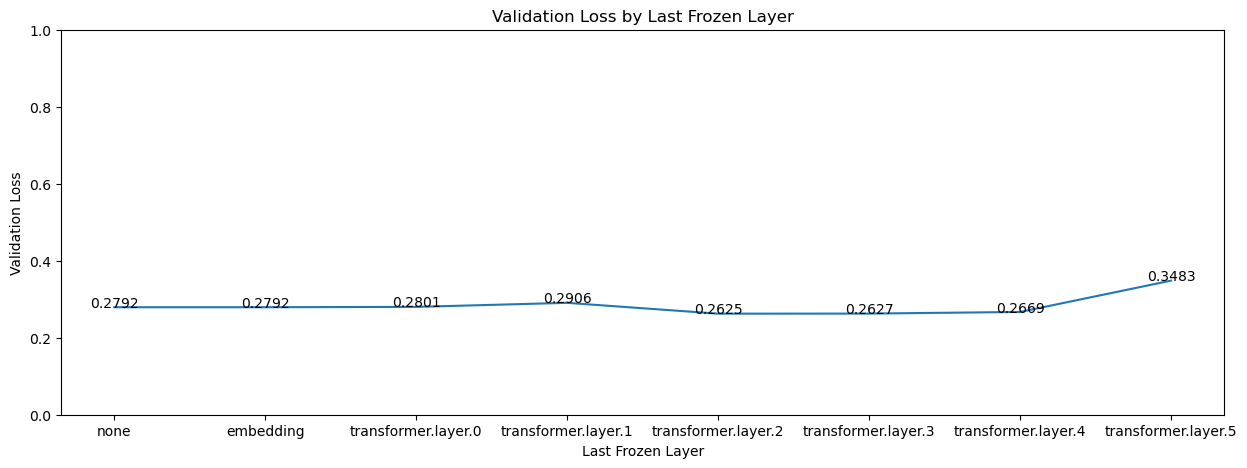

In [24]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['validation_metrics']['eval_loss']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Validation Loss'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

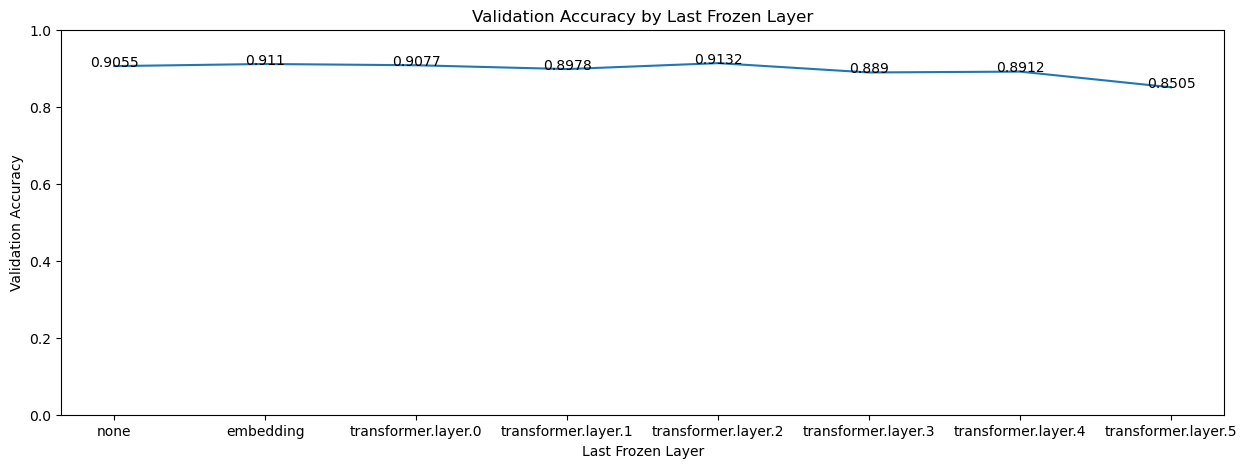

In [25]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['validation_metrics']['eval_accuracy']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Validation Accuracy'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

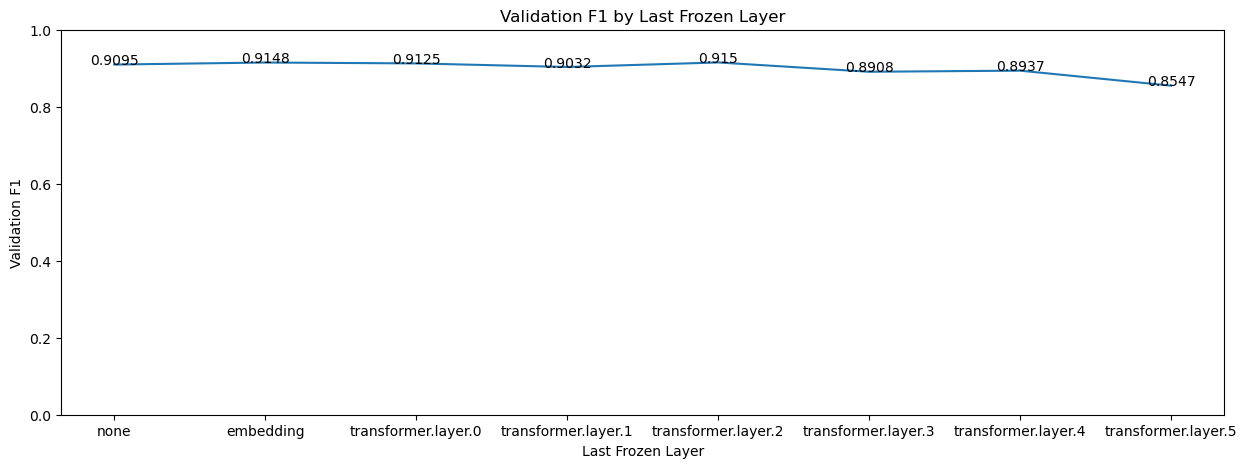

In [26]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['validation_metrics']['eval_f1']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Validation F1'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

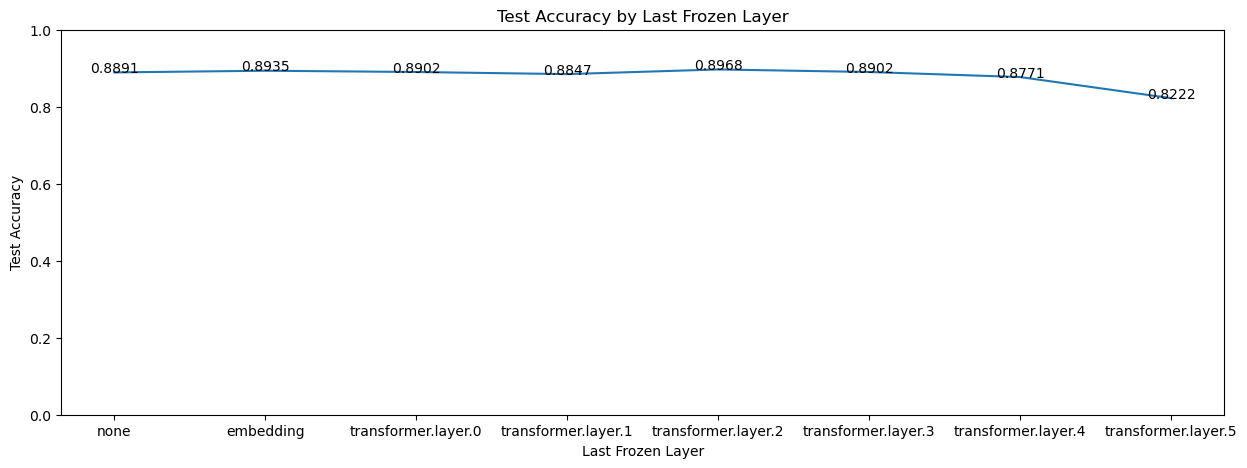

In [27]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['finetuned_test_metrics']['eval_accuracy']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Test Accuracy'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

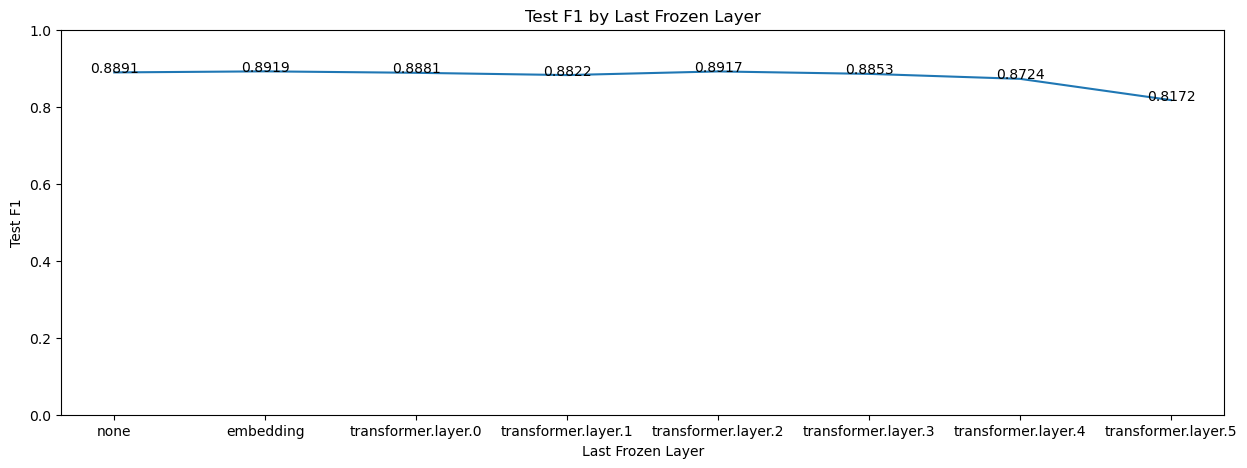

In [28]:
# get results
name_list = []
results_list = []
for row in results:
    name_list.append(row['name'])
    results_list.append(float(f"{row['finetuned_test_metrics']['eval_f1']:.4f}"))

# plot graph
xlabel = 'Last Frozen Layer'
ylabel = 'Test F1'
fig, axs = plt.subplots(nrows=1, figsize=(15,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

# Conclusion
- Freezing the entire DistilBERT model without its Classification LM head reduces the amount of trainable parameters by 99.12%.
- The more layers that are frozen, the faster training runtime (2.4X), training samples per second (2.4X), training steps per second (2.4X), which is expected.
- Training loss is the lowest in unfrozen model (0.0664), while it's highest in most frozen model (0.4265), which is also expected.
- Interestingly, the lowest validation loss among the models are similar from 0.2625 to 0.3493 with just an absolute min-max difference of 0.0868.
- Also, there is a slight decerease in the lowest validation loss for the last 2 models, while all others are roughly the same.
- This trend of having similar performance among the models except the last 2 models are seen in validation accuracy, validation F1, test accuracy, and test F1.
- Also interestingly, freezing just the embedding layer seems to increase performance both in validation and test.

**Based on these results:**
- It would not be an invalid approach to freeze most layers in DistilBert and keep at least 1 transformer layer particularly the last to reduce compute time and cost.
- It would not be an invalid approach to freeze the embedding layers as a general practice to reduce the trainable parameters by around 40%.

**However, more research in layer freezing is required with a broader NLP model variety, dataset variety, and tasks to make an general advice on the best way to layer freeze in the NLP domain.**